In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#connnecting drive with google colab
from google.colab import drive
drive.mount('/content/drive/')
#read the csv file 
macro_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Final_csv/RELIANCE.csv', parse_dates= ['Datetime'], index_col='Datetime')

Mounted at /content/drive/


In [3]:
print(macro_data.shape)  
macro_data.head()

(6404, 6)


,Open,High,Low,Close,Volume,Trading_code
Datetime,,,,,,
2021-04-26 09:15:00+05:30,1920.00,1930.00,1912.00,1926.85,1061804,RELIANCE
2021-04-26 09:30:00+05:30,1927.00,1936.10,1925.05,1935.05,652372,RELIANCE
2021-04-26 09:45:00+05:30,1935.20,1949.75,1935.05,1949.25,707257,RELIANCE
2021-04-26 10:00:00+05:30,1949.15,1961.60,1949.10,1955.00,915519,RELIANCE
2021-04-26 10:15:00+05:30,1955.05,1958.20,1947.60,1950.95,609119,RELIANCE


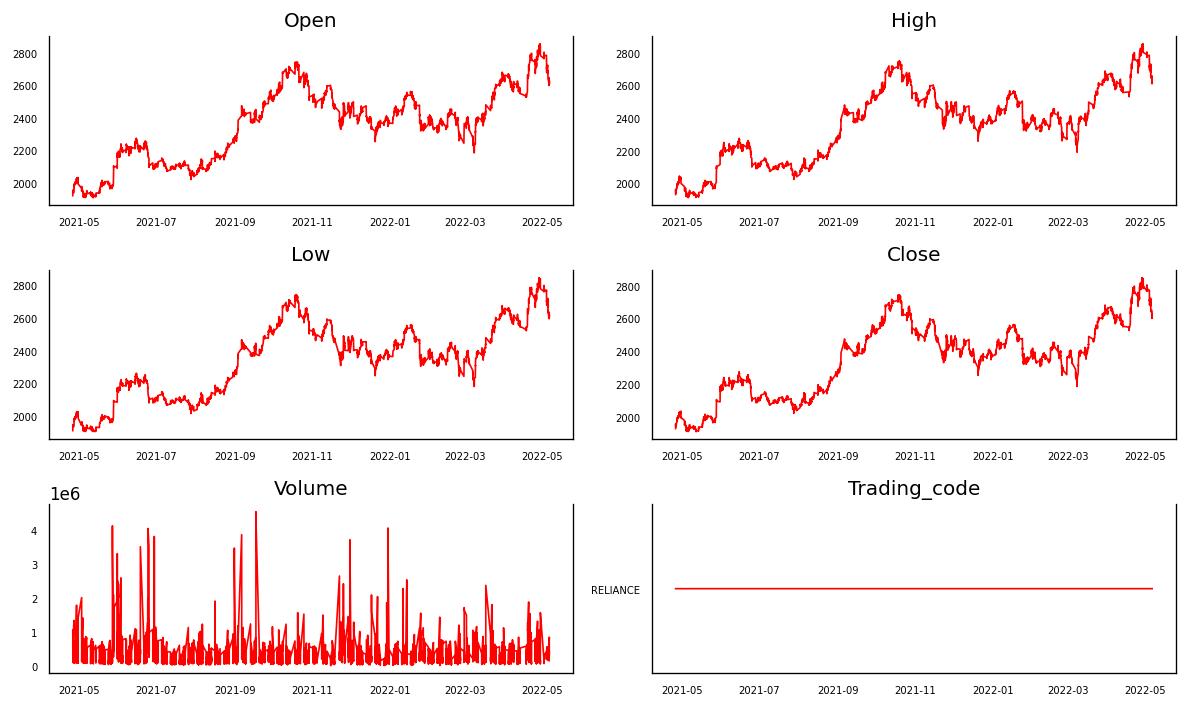

In [4]:
fig, axes = plt.subplots( nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [5]:
macro_data = macro_data.dropna()

In [6]:
macro_data.head()

,Open,High,Low,Close,Volume,Trading_code
Datetime,,,,,,
2021-04-26 09:15:00+05:30,1920.00,1930.00,1912.00,1926.85,1061804,RELIANCE
2021-04-26 09:30:00+05:30,1927.00,1936.10,1925.05,1935.05,652372,RELIANCE
2021-04-26 09:45:00+05:30,1935.20,1949.75,1935.05,1949.25,707257,RELIANCE
2021-04-26 10:00:00+05:30,1949.15,1961.60,1949.10,1955.00,915519,RELIANCE
2021-04-26 10:15:00+05:30,1955.05,1958.20,1947.60,1950.95,609119,RELIANCE


Checking if data is stationary or not. If p value is less than 0.05 than data is stationary otherwise data is not stationary. By doing 1st order differencing we are making the data stationary.

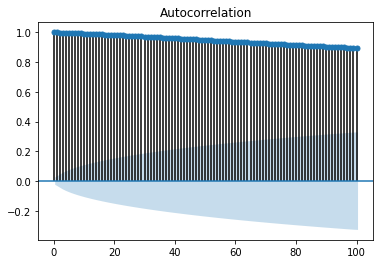

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(macro_data['Open'], lags=100)
plt.show()

In [ ]:

for i in range(len(macro_data.columns)):
  result = adfuller(macro_data[macro_data.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(macro_data.columns[i]))
  else:
    print('{} - Series is Stationary'.format(macro_data.columns[i]))

Open - Series is not Stationary
High - Series is not Stationary
Low - Series is not Stationary
Close - Series is not Stationary
Volume - Series is Stationary
6 - Series is Stationary


Granger Causality test is used to check correlation between the two time series. Tells whether the time series in the second column causes the time series in the first column. Currently doing for 8 lags but we can do for multiple lags. If p=0 means the second column causes the time series in the first column.

In [ ]:
dataset=macro_data.drop(["Volume"],axis= 1)
dataset=macro_data.drop(["6"],axis= 1)

In [ ]:
max_lags=8
y='Close'
for i in range(len(dataset.columns)-1):
  results=grangercausalitytests(dataset[[y,dataset.columns[i+1]]], max_lags, verbose=False)
  p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
  print('Column - {} : P_Values - {}'.format(dataset.columns[i+1],p_values))

Column - High : P_Values - [0.4783, 0.0616, 0.2134, 0.3049, 0.3043, 0.2986, 0.2851, 0.2083]
Column - Low : P_Values - [0.4983, 0.3169, 0.8752, 0.8136, 0.8396, 0.9187, 0.9466, 0.9438]
Column - Close : P_Values - [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Column - Volume : P_Values - [0.8303, 0.4331, 0.4077, 0.5158, 0.6174, 0.7638, 0.77, 0.8324]


In [ ]:
df_train = dataset[:int(0.95*(len(dataset)))]
df_test = dataset[int(0.95*(len(dataset))):]

In [ ]:
df_train.shape

(1971, 5)

In [ ]:
df_test.shape

(104, 5)

Select order help us to select the maximum lags. For a good model all the parameters should be minimum as possible. Normally only looking at AIC score is also sufficient. Star highlight where minimum is found. We need to consider that lag where minimum was found was further processing.

In [ ]:
model = VAR(df_train)
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,41.90,41.92,1.579e+18,41.91
1,34.91,34.99*,1.444e+15,34.94*
2,34.90*,35.05,1.429e+15*,34.95
3,34.90,35.12,1.429e+15,34.98
4,34.90,35.20,1.436e+15,35.01
5,34.91,35.28,1.453e+15,35.05
6,34.92,35.36,1.467e+15,35.08
7,34.93,35.45,1.482e+15,35.12
8,34.95,35.53,1.502e+15,35.16
9,34.96,35.62,1.521e+15,35.20


In [ ]:
results = model.fit(3)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Apr, 2022
Time:                     16:24:40
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    35.1219
Nobs:                     1968.00    HQIC:                   34.9783
Log likelihood:          -48218.9    FPE:                1.42770e+15
AIC:                      34.8948    Det(Omega_mle):     1.37106e+15
--------------------------------------------------------------------
Results for equation Open
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             2.053137         2.275601            0.902           0.367
L1.Open          -0.010269         0.035267           -0.291           0.771
L1.High           0.060210         0.038472            1.565           0.118


VARMAX Class make forecasting easier. We are providing the non stationary data and not difference data. Order(Autoregression,Moving Average part).Enforce stationarity will make are data stationary.

In [ ]:
lag=results.k_ar

In [ ]:
results.forecast(df_train.values[-lag:],steps=5)

array([[  2626.14866351,   2629.85641257,   2622.28583389,
          2625.92490353, 149352.0404015 ],
       [  2625.78259434,   2629.7353898 ,   2621.89577107,
          2625.94652431, 171846.77737302],
       [  2625.71279892,   2629.83837117,   2621.72988351,
          2625.84798911, 189661.74674924],
       [  2625.66695067,   2629.80686334,   2621.53825296,
          2625.67606075, 198452.18667971],
       [  2625.48357447,   2629.67321736,   2621.28432597,
          2625.48810735, 203077.8766187 ]])

In [ ]:
fc = results.forecast(df_test.values[-lag:], steps=330)
df_forecast = pd.DataFrame(fc, index=macro_data.index[-330:], columns=df_train.columns + '_forecast')
df_forecast

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Volume_forecast
Datetime,,,,,
2022-03-29 14:15:00+05:30,2623.849177,2634.366714,2614.531202,2625.389115,727436.758921
2022-03-29 14:30:00+05:30,2625.293271,2631.543489,2615.513328,2621.829418,514163.111402
2022-03-29 14:45:00+05:30,2621.772415,2627.529557,2614.393143,2620.274211,384476.259339
2022-03-29 15:00:00+05:30,2620.060502,2625.359320,2613.995664,2619.480654,303368.395840
2022-03-29 15:15:00+05:30,2619.382139,2624.171376,2613.913930,2618.739740,263548.925625
...,...,...,...,...,...
2022-04-19 14:15:00+05:30,2565.262741,2569.621636,2560.837852,2565.294937,219783.800535
2022-04-19 14:30:00+05:30,2565.143571,2569.502713,2560.718444,2565.175928,219807.627735
2022-04-19 14:45:00+05:30,2565.024630,2569.384017,2560.599266,2565.057147,219831.409296


In [ ]:
# Common code for display result
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().endswith('_forecast'):
            data[col].plot(label=col,linestyle="dashed")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()

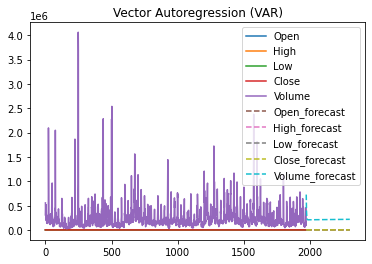

In [ ]:
show_graph(df_train, df_forecast, "Vector Autoregression (VAR)")

In [ ]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_Open=math.sqrt(mean_squared_error(df_forecast['Open_forecast'],df_test['Open']))
print('Mean value of Open is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['Open']),rmse_Open))
rmse_High=math.sqrt(mean_squared_error(df_forecast['High_forecast'],df_test['High']))
print('Mean value of High is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['High']),rmse_High))
rmse_Low=math.sqrt(mean_squared_error(df_forecast['Low_forecast'],df_test['Low']))
print('Mean value of Low is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['Low']),rmse_Low))
rmse_Close=math.sqrt(mean_squared_error(df_forecast['Close_forecast'],df_test['Close']))
print('Mean value of Close is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['Close']),rmse_Close))
rmse_AdjClose=math.sqrt(mean_squared_error(df_forecast['Adj Close_forecast'],df_test['Adj Close']))
print('Mean value of Adj Close is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['Adj Close']),rmse_AdjClose))

ValueError: ignored